<img src = 'https://media.nationalgeographic.org/assets/photos/000/273/27302_c0-41-990-701_r1050x700.jpg?d4ccf3044d9da0d0118103be3a76bd1319370847' >

## Brief Introduction about Titanic Ship
Titanic was a British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters.
Though there were about 2,224 passengers and crew members, we are given data of about 1,300 passengers. Out of these 1,300 passengers details, about 9000 data is used for training purpose and remaining 400 is used for test purpose. In this competition we are given about 400 test data with missing survived column and we have to use different machine learning algorithms to predict whether the passengers in the test data survived or not.
Both training and test data arenot clean(contains lots of missing values), so main goal of this competition is to clean the data and build the model with best accuracy.

## Understanding the data



Survival : 0 = No, 1 = Yes

Pclass : A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

sibsp : The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = 

husband, wife (mistresses and fiancés were ignored)

parch : The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, 
stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

Ticket : Ticket number

Fare : Passenger fare

Cabin : Cabin number embarked

Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

Name, Sex , Age are self-explanatory



## Importing all necessary libraries


In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import enum
import os
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
class Mode(enum.Enum):
    TRAIN = "TRAIN"
    TEST = "TEST"

## Define the current run-mode

In [3]:
import platform

PC_NAME = platform.node().replace(" ", "_").replace(".", "_")
MODEL_DIR = f"../../output/titanic/models/{PC_NAME}"
MODE = Mode.TEST
if MODE == Mode.TEST and not os.path.exists(MODEL_DIR):
    print(f"Error: model not created (path \"{MODEL_DIR}\" does not exist), mode will be Mode.TRAIN")
    MODE = Mode.TRAIN

Error: model not created (path "../../output/titanic/models/MacBook-Pro-van-Bo_local" does not exist), mode will be Mode.TRAIN


### Load the data

In [4]:
train_data = pd.read_csv('../../input/titanic/train.csv')
test_data = pd.read_csv('../../input/titanic/test.csv')

# Dealing with the Missing values

In [5]:
# before filling the missing values, let's drop Cabin column from both data.
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [6]:
combined_data = [train_data, test_data]
for data in combined_data:
    print(data.isnull().sum())
    print('*' * 20)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
********************
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64
********************


In [7]:
# filling the nan values fo Age and fare column with the mean while Embarked column with most_frequent value
for data in combined_data:
    data.Age.fillna(data.Age.mean(), inplace=True)
    data.Fare.fillna(data.Fare.mean(), inplace=True)

# from visualization we know that Southamptom is most frequent Embarked place so, filling the missing value 
# with 'S'
train_data.Embarked.fillna('S', inplace=True)

## Converting a categorical feature¶



##### Let's  start by converting Sex feature to categorical  female=1 and male=0

In [8]:
def change_gender(x):
    if x == 'male':
        return 0
    elif x == 'female':
        return 1


train_data.Sex = train_data.Sex.apply(change_gender)
test_data.Sex = test_data.Sex.apply(change_gender)

**using map funcion to change the Embarked column S = 1, C = 2, Q = 0**

In [9]:
change = {'S': 1, 'C': 2, 'Q': 0}
train_data.Embarked = train_data.Embarked.map(change)
test_data.Embarked = test_data.Embarked.map(change)

# Feature Extraction


while visualizing the correlation heatmap we came to know that Sibsp and Parch columns were closely related 
so lets created new column called Alone using this two columns
-------> 1 = Alone , 0 = not Alone

In [10]:
train_data['Alone'] = train_data.SibSp + train_data.Parch
test_data['Alone'] = test_data.SibSp + test_data.Parch

train_data.Alone = train_data.Alone.apply(lambda x: 1 if x == 0 else 0)
test_data.Alone = test_data.Alone.apply(lambda x: 1 if x == 0 else 0)

In [11]:
# now lets drop SibSp and Parch column for both training and testing data
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# Creating new feature Title extracting from existing feature Name


In [12]:
train_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False).unique().size

17

In [13]:
# lets create the Title feature which contain the title of the passenger and drop Name column
for data in combined_data:
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    data.drop('Name', axis=1, inplace=True)

In [14]:
train_data.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [15]:
test_data.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [16]:
#lets replace least occuring title in the data with rare
least_occuring = ['Don', 'Rev', 'Dr', 'Mme', 'Ms',
                  'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Dona',
                  'Jonkheer']
for data in combined_data:
    data.Title = data.Title.replace(least_occuring, 'Rare')

In [17]:
# lets perform title mapping in order to change to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in combined_data:
    data['Title'] = data['Title'].map(title_mapping)

# Dropping PassengerId and Ticket column

In [18]:
columns_to_drop = ['PassengerId', 'Ticket']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop[1], axis=1, inplace=True)

## Binning Age and Fare columns

In [19]:
for dataset in combined_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [20]:
for data in combined_data:
    data.loc[data['Fare'] < 30, 'Fare'] = 1
    data.loc[(data['Fare'] >= 30) & (data['Fare'] < 50), 'Fare'] = 2
    data.loc[(data['Fare'] >= 50) & (data['Fare'] < 100), 'Fare'] = 3
    data.loc[(data['Fare'] >= 100), 'Fare'] = 4

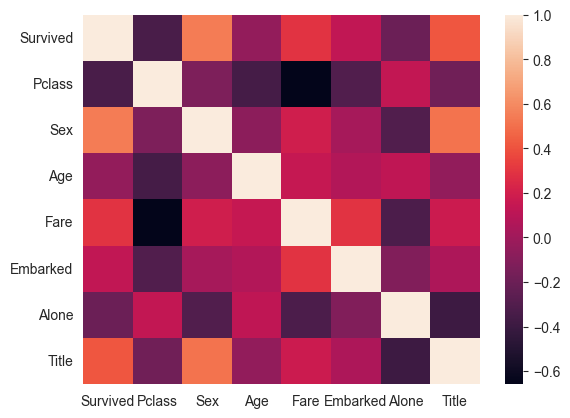

In [21]:
corr_train = train_data.corr()
sns.heatmap(corr_train)
plt.show()

# preparing training and testing data

In [22]:
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.models import Sequential

2023-03-19 13:58:58.480049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test = test_data.drop("PassengerId", axis=1)
Y_train = to_categorical(np.array(Y_train), num_classes=2)
Y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

## Import necessary libraries

## Defining model
Here, I have used different number of neurons for each layer and different value for dropout. You can play with these hyperparameter for better outut.

In [25]:
def make_model():
    model = Sequential()
    model.add(Dense(units=16, input_shape=(7,), activation='relu'))
    # model.add(tf.keras.layers.BatchNormalization())
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_normal', use_bias=False))
    model.add(Dense(units=2, activation='softmax'))
    return model


model = make_model()

### Model summary

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                512       
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 706
Trainable params: 706
Non-trainable params: 0
_________________________________________________________________


## Compiling and fitting model

In [27]:
if MODE == Mode.TRAIN:
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])
    model.fit(X_train, Y_train, batch_size=32, verbose=2, epochs=100)
    model.save(MODEL_DIR)
else:
    model.load_weights(MODEL_DIR)

Epoch 1/100
28/28 - 1s - loss: 1.2459 - acc: 0.6162 - 940ms/epoch - 34ms/step
Epoch 2/100
28/28 - 0s - loss: 0.8010 - acc: 0.6128 - 37ms/epoch - 1ms/step
Epoch 3/100
28/28 - 0s - loss: 0.6637 - acc: 0.6218 - 38ms/epoch - 1ms/step
Epoch 4/100
28/28 - 0s - loss: 0.5565 - acc: 0.7273 - 38ms/epoch - 1ms/step
Epoch 5/100
28/28 - 0s - loss: 0.4920 - acc: 0.7946 - 37ms/epoch - 1ms/step
Epoch 6/100
28/28 - 0s - loss: 0.4632 - acc: 0.7924 - 37ms/epoch - 1ms/step
Epoch 7/100
28/28 - 0s - loss: 0.4515 - acc: 0.7935 - 35ms/epoch - 1ms/step
Epoch 8/100
28/28 - 0s - loss: 0.4439 - acc: 0.8103 - 36ms/epoch - 1ms/step
Epoch 9/100
28/28 - 0s - loss: 0.4412 - acc: 0.8114 - 34ms/epoch - 1ms/step
Epoch 10/100
28/28 - 0s - loss: 0.4371 - acc: 0.8103 - 33ms/epoch - 1ms/step
Epoch 11/100
28/28 - 0s - loss: 0.4337 - acc: 0.8193 - 33ms/epoch - 1ms/step
Epoch 12/100
28/28 - 0s - loss: 0.4331 - acc: 0.8137 - 33ms/epoch - 1ms/step
Epoch 13/100
28/28 - 0s - loss: 0.4316 - acc: 0.8260 - 33ms/epoch - 1ms/step
Epoch 

INFO:tensorflow:Assets written to: ../../output/titanic/models/MacBook-Pro-van-Bo_local/assets


INFO:tensorflow:Assets written to: ../../output/titanic/models/MacBook-Pro-van-Bo_local/assets


**Prediction for test data**

In [28]:
predict = model.predict(X_test)
predict = np.array([0 if p[0] > 0.5 else 1 for p in predict]).astype(int).ravel()
predict

14/14 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

# For submission

In [29]:
submit = pd.DataFrame({"PassengerId": test_data.PassengerId, 'Survived': predict})
submit.to_csv("../../output/titanic/death_prediction_per_passenger.csv", index=False)

In [30]:
from sklearn import metrics

Y_pred_rand = [0 if x[0] > x[1] else 1 for x in model.predict(X_train)]
Y_train_flat = [0 if x[0] > x[1] else 1 for x in Y_train]
print('Precision : ', np.round(metrics.precision_score(Y_train_flat, Y_pred_rand) * 100, 2))
print('Accuracy : ', np.round(metrics.accuracy_score(Y_train_flat, Y_pred_rand) * 100, 2))
print('Recall : ', np.round(metrics.recall_score(Y_train_flat, Y_pred_rand) * 100, 2))
print('F1 score : ', np.round(metrics.f1_score(Y_train_flat, Y_pred_rand) * 100, 2))
print('AUC : ', np.round(metrics.roc_auc_score(Y_train_flat, Y_pred_rand) * 100, 2))

28/28 [==============================] - 0s 1ms/step
Precision :  90.12
Accuracy :  83.5
Recall :  64.04
F1 score :  74.87
AUC :  79.83


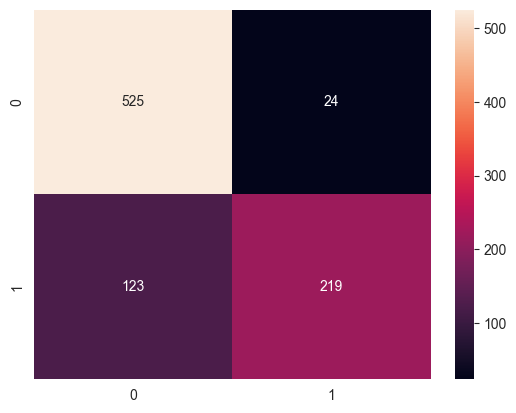

In [31]:
# plotting the confusion matrix in heatmap
matrix = metrics.confusion_matrix(Y_train_flat, Y_pred_rand)
sns.heatmap(matrix, annot=True, fmt='g')
plt.show()

# Co-Activation Graph

14/14 [==============================] - 0s 1ms/step
[[ 1.         -0.11878753  0.34587685 ... -0.13625945  0.13625945
  -0.13625945]
 [-0.11878753  1.          0.24389822 ... -0.06747676  0.06747676
  -0.06747676]
 [ 0.34587685  0.24389822  1.         ... -0.32644415  0.32644415
  -0.32644415]
 ...
 [-0.13625945 -0.06747676 -0.32644415 ...  1.         -1.
   1.        ]
 [ 0.13625945  0.06747676  0.32644415 ... -1.          1.
  -1.        ]
 [-0.13625945 -0.06747676 -0.32644415 ...  1.         -1.
   1.        ]]


/Library/Python/3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Python/3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


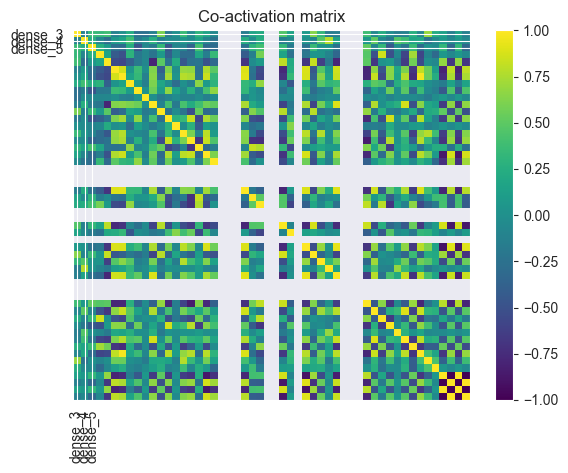

In [32]:
x = X_test

# Compute intermediate layer activations
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(name).output for name in layer_names]
model_reduced = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)
activations = model_reduced.predict(x)

# Compute model predictions on test data
predictions = [x for x in model.predict(x)]

# Concatenate predictions to activations
# Compute pairwise correlations between activations
activations_flat = np.concatenate([a.reshape(a.shape[0], -1) for a in activations], axis=1)
activations_flat = np.array([np.append(a, p) for a, p in zip(activations_flat, predictions)])
correlations = np.corrcoef(activations_flat, rowvar=False)
print(correlations)
# Plot co-activation matrix
plt.imshow(correlations, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Co-activation matrix')
plt.xticks(np.arange(len(layer_names)), layer_names, rotation=90)
plt.yticks(np.arange(len(layer_names)), layer_names)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Clusters: [{32, 1, 42, 33}, {5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 22, 28, 30, 34, 39, 41, 43, 45, 49, 51}, {0, 2, 3, 4, 7, 11, 16, 23, 24, 27, 31, 38, 40, 44, 46, 47, 48, 50}]


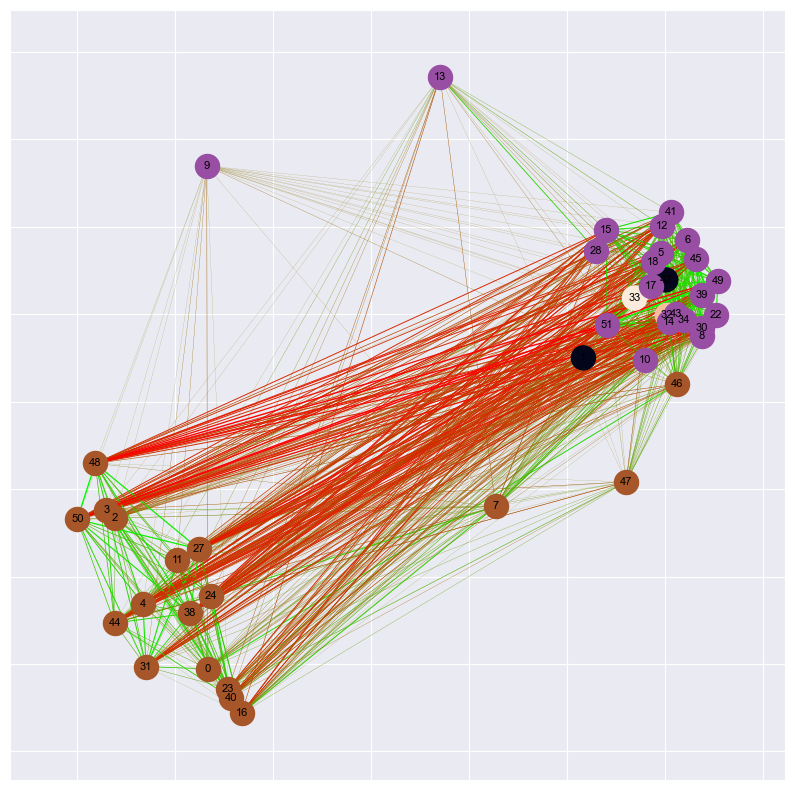

In [81]:
import networkx as nx
import matplotlib.colors as mcolors
from networkx.algorithms.community import louvain_communities

# defines the correlation threshold for the edges (0=everything will be shown, range=(-1,1))
threshold = 0

# Create the graph
G = nx.Graph()
for i in range(correlations.shape[0]):
    for j in range(i + 1, correlations.shape[1]):
        if abs(correlations[i, j]) >= threshold:
            G.add_edge(i, j, weight=correlations[i, j])
clusters = louvain_communities(G, weight='weight', resolution=1.2, threshold=0.5, seed=123)

# Draw the graph
fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(G, weight='weight')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=50)
nx.draw_networkx_labels(G, pos, font_size=8)

edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edges = list(edges)
weights = list(weights)

# this part will do the edge colorization
min_w, max_w = -1, 1
red = mcolors.hex2color('#FF0000')  # red color in RGB format
green = mcolors.hex2color('#00FF00')  # green color in RGB format
edge_colors = []
for w in weights:
    # Map the weight value to a value between 0 and 1
    normalized_w = (w - min_w) / (max_w - min_w)

    # Use a linear interpolation to determine the color between red and green
    color = tuple((1 - normalized_w) * c1 + normalized_w * c2 for c1, c2 in zip(red, green))

    # Convert the color to hexadecimal format and append it to the list
    edge_colors.append(mcolors.rgb2hex(color))

# draw the network edges
edges, weights = zip(*[(edges[i], round(weights[i], 1)) for i in range(len(edges)) if abs(weights[i]) >= threshold])
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=weights, edge_cmap=plt.cm.coolwarm, )

# draw the louvain communities
colors = {}
for i, community in enumerate(clusters):
    color = plt.cm.Set1(i / len(clusters))
    colors.update({node: color for node in community})

for c in clusters:
    nx.draw_networkx_nodes(G, pos, nodelist=list(c), node_color=colors[list(c)[0]], node_size=300)
print(f"Clusters: {clusters}")
plt.show()

## SHAP (SHapley Additive exPlanations)

In [84]:
import shap
import logging
import pickle
import os

recalc = True
logging.getLogger('shap').setLevel(logging.WARNING)

shap_values_full_model_fname = f"{MODEL_DIR}/shap_values_full_model.txt"
shap_values_full_per_cluster_fname = f"{MODEL_DIR}/shap_values_per_cluster.txt"
shap_values_full_per_feature_fname = f"{MODEL_DIR}/shap_values_per_feature.txt"

In [105]:
def sample_size_full_model():
    return 500


def relative_node_sample_size(cluster_size):
    return sample_size_full_model() / cluster_size

### Full SHAP

In [86]:
def do_or_load_and_write(func, file):
    if not recalc and os.path.exists(file):
        print(f'loading from file {file}')
        with open(file, 'rb') as f:
            return pickle.load(f)
    else:
        print(f'not loading from file {file}, running func and returning...')
        r = func()
        with open(file, 'wb') as f:
            pickle.dump(r, f)
        return r

In [87]:
% % capture test

# This is the full SHAP explainer (begin layer to end layer)
def _2_class_to_binary_f(X, model):
    return np.array([0 if x[0] > x[1] else 1 for x in model.predict(X)])


def calc_full_shap():
    full_explainer = shap.Explainer(lambda x: _2_class_to_binary_f(x, model), X_test)
    sample_size = sample_size_full_model()
    print(f"Using full-model sample size {sample_size_full_model()}")
    return full_explainer(shap.utils.sample(X_test, sample_size))

In [88]:
% % capture test
full_shap_values = do_or_load_and_write(calc_full_shap, shap_values_full_model_fname)

In [89]:
def get_aggregated_model_shap(clazz, agg_func=np.mean) -> dict:
    assert clazz in {0, 1}
    return {f: agg_func(np.abs(full_shap_values.values[:, idx])) * (1 if clazz == 0 else -1) for idx, f in
            enumerate(X_train.columns)}


survived_mean_shap_vals = get_aggregated_model_shap(clazz=1)
died_mean_shap_vals = get_aggregated_model_shap(clazz=0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


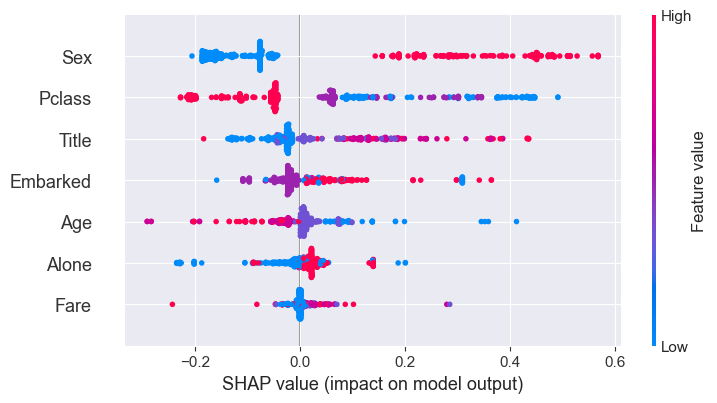

In [90]:
shap.plots.beeswarm(full_shap_values)

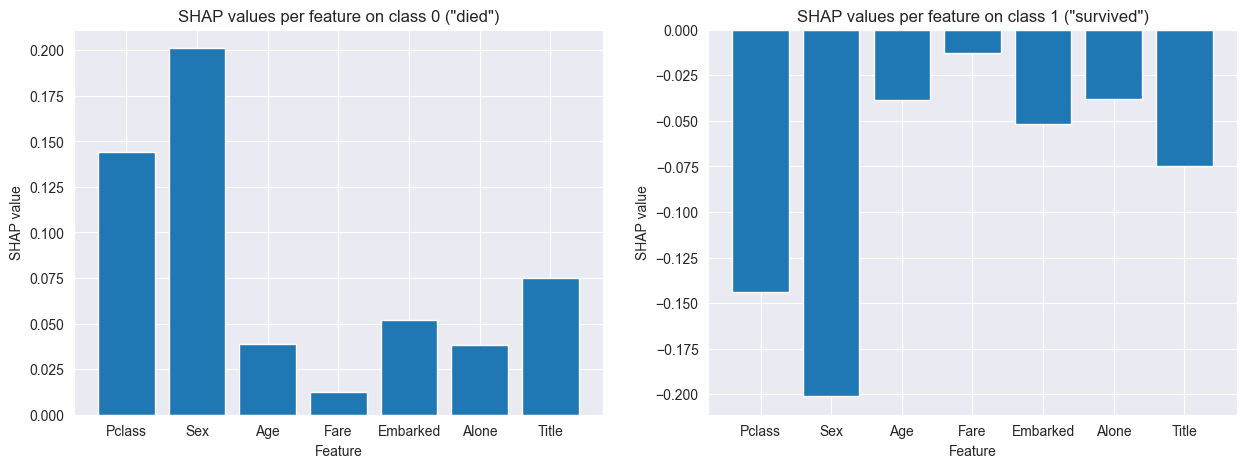

In [91]:
fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(15, 5))
axs[0].bar(died_mean_shap_vals.keys(), died_mean_shap_vals.values())
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('SHAP value')
axs[0].set_title('SHAP values per feature on class 0 ("died")')

axs[1].bar(survived_mean_shap_vals.keys(), survived_mean_shap_vals.values())
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('SHAP value')
axs[1].set_title('SHAP values per feature on class 1 ("survived")')
plt.show()

### Clustered SHAP

In [92]:
clusters

[{1, 32, 33, 42},
 {5,
  6,
  8,
  9,
  10,
  12,
  13,
  14,
  15,
  17,
  18,
  22,
  28,
  30,
  34,
  39,
  41,
  43,
  45,
  49,
  51},
 {0, 2, 3, 4, 7, 11, 16, 23, 24, 27, 31, 38, 40, 44, 46, 47, 48, 50}]

In [93]:
named_clusters = {f"cluster_{i}": c for i, c in enumerate(clusters)}
print(named_clusters)

{'cluster_0': {32, 1, 42, 33}, 'cluster_1': {5, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 22, 28, 30, 34, 39, 41, 43, 45, 49, 51}, 'cluster_2': {0, 2, 3, 4, 7, 11, 16, 23, 24, 27, 31, 38, 40, 44, 46, 47, 48, 50}}


#### Steps new SHAP-research idea
1. Per node, per instance, activation SHAP values (per instance)
2. Per cluster, per feature, SHAP distribution
3. General SHAP values per feature on entire model
4. Check where general SHAP values per feature lay within the distribution per feature per cluster

In [94]:
nodes = set()
for c in clusters:
    for node in c:
        nodes.add(node)
print(f"Number of nodes: {len(nodes)}")

Number of nodes: 43


In [95]:
model_function_per_node = {}
node_num = 0
for layer_id, layer in enumerate(model.layers):
    m = tf.keras.Model(inputs=model.input, outputs=layer.output)
    for i in range(layer.output.shape[1]):
        if node_num in nodes:
            model_function_per_node[node_num] = m
        node_num += 1

In [96]:
def node_activation_f(X, node: int):
    if node in model_function_per_node:
        m = model_function_per_node[node]
        local_node_num = node % m.output.shape[1]
        return np.array([x[local_node_num] for x in m.predict(X)])
    raise Exception(f"{n} not in {model_function_per_node.keys()}")

In [108]:
%%capture test
nodes = [n for n in model_function_per_node.keys()]

clusters_size_per_node = {}
for c in clusters:
    for n in c:
        clusters_size_per_node[n] = len(c)

In [109]:
clusters_size_per_node

{32: 4,
 1: 4,
 42: 4,
 33: 4,
 5: 21,
 6: 21,
 8: 21,
 9: 21,
 10: 21,
 12: 21,
 13: 21,
 14: 21,
 15: 21,
 17: 21,
 18: 21,
 22: 21,
 28: 21,
 30: 21,
 34: 21,
 39: 21,
 41: 21,
 43: 21,
 45: 21,
 49: 21,
 51: 21,
 0: 18,
 2: 18,
 3: 18,
 4: 18,
 7: 18,
 11: 18,
 16: 18,
 23: 18,
 24: 18,
 27: 18,
 31: 18,
 38: 18,
 40: 18,
 44: 18,
 46: 18,
 47: 18,
 48: 18,
 50: 18}

In [110]:
def calc_shap_per_feature():
    shap_values_per_feature = {x: {n: [] for n in nodes} for x in X_train.columns}

    current_node_number = nodes[0]
    ex = shap.Explainer(lambda x: node_activation_f(x, current_node_number), X_train)
    for n in nodes:
        sample_size = int(np.ceil(relative_node_sample_size(clusters_size_per_node[n])))
        sample = shap.utils.sample(X_test, sample_size)
        current_node_number = n
        vals = ex(sample).values
        for svarr in vals:
            for idx, sv in enumerate(svarr, 0):
                shap_values_per_feature[X_train.columns[idx]][n].append(sv)
    return shap_values_per_feature

In [111]:
%%capture test
shap_values_per_feature = do_or_load_and_write(calc_shap_per_feature, shap_values_full_per_feature_fname)

In [113]:
def calc_shap_per_cluster():
    shap_values_per_cluster = {c: {f: [] for f in X_train.columns} for c in named_clusters.keys()}
    for feature, n_sv in shap_values_per_feature.items():
        for node, sv in n_sv.items():
            for c_name, nodes in named_clusters.items():
                if node in nodes:
                    for _sv in sv:
                        shap_values_per_cluster[c_name][feature].append(_sv)
    return shap_values_per_cluster

In [114]:
shap_values_per_cluster = do_or_load_and_write(calc_shap_per_cluster, shap_values_full_per_cluster_fname)

not loading from file ../../output/titanic/models/MacBook-Pro-van-Bo_local/shap_values_per_cluster.txt, running func and returning...


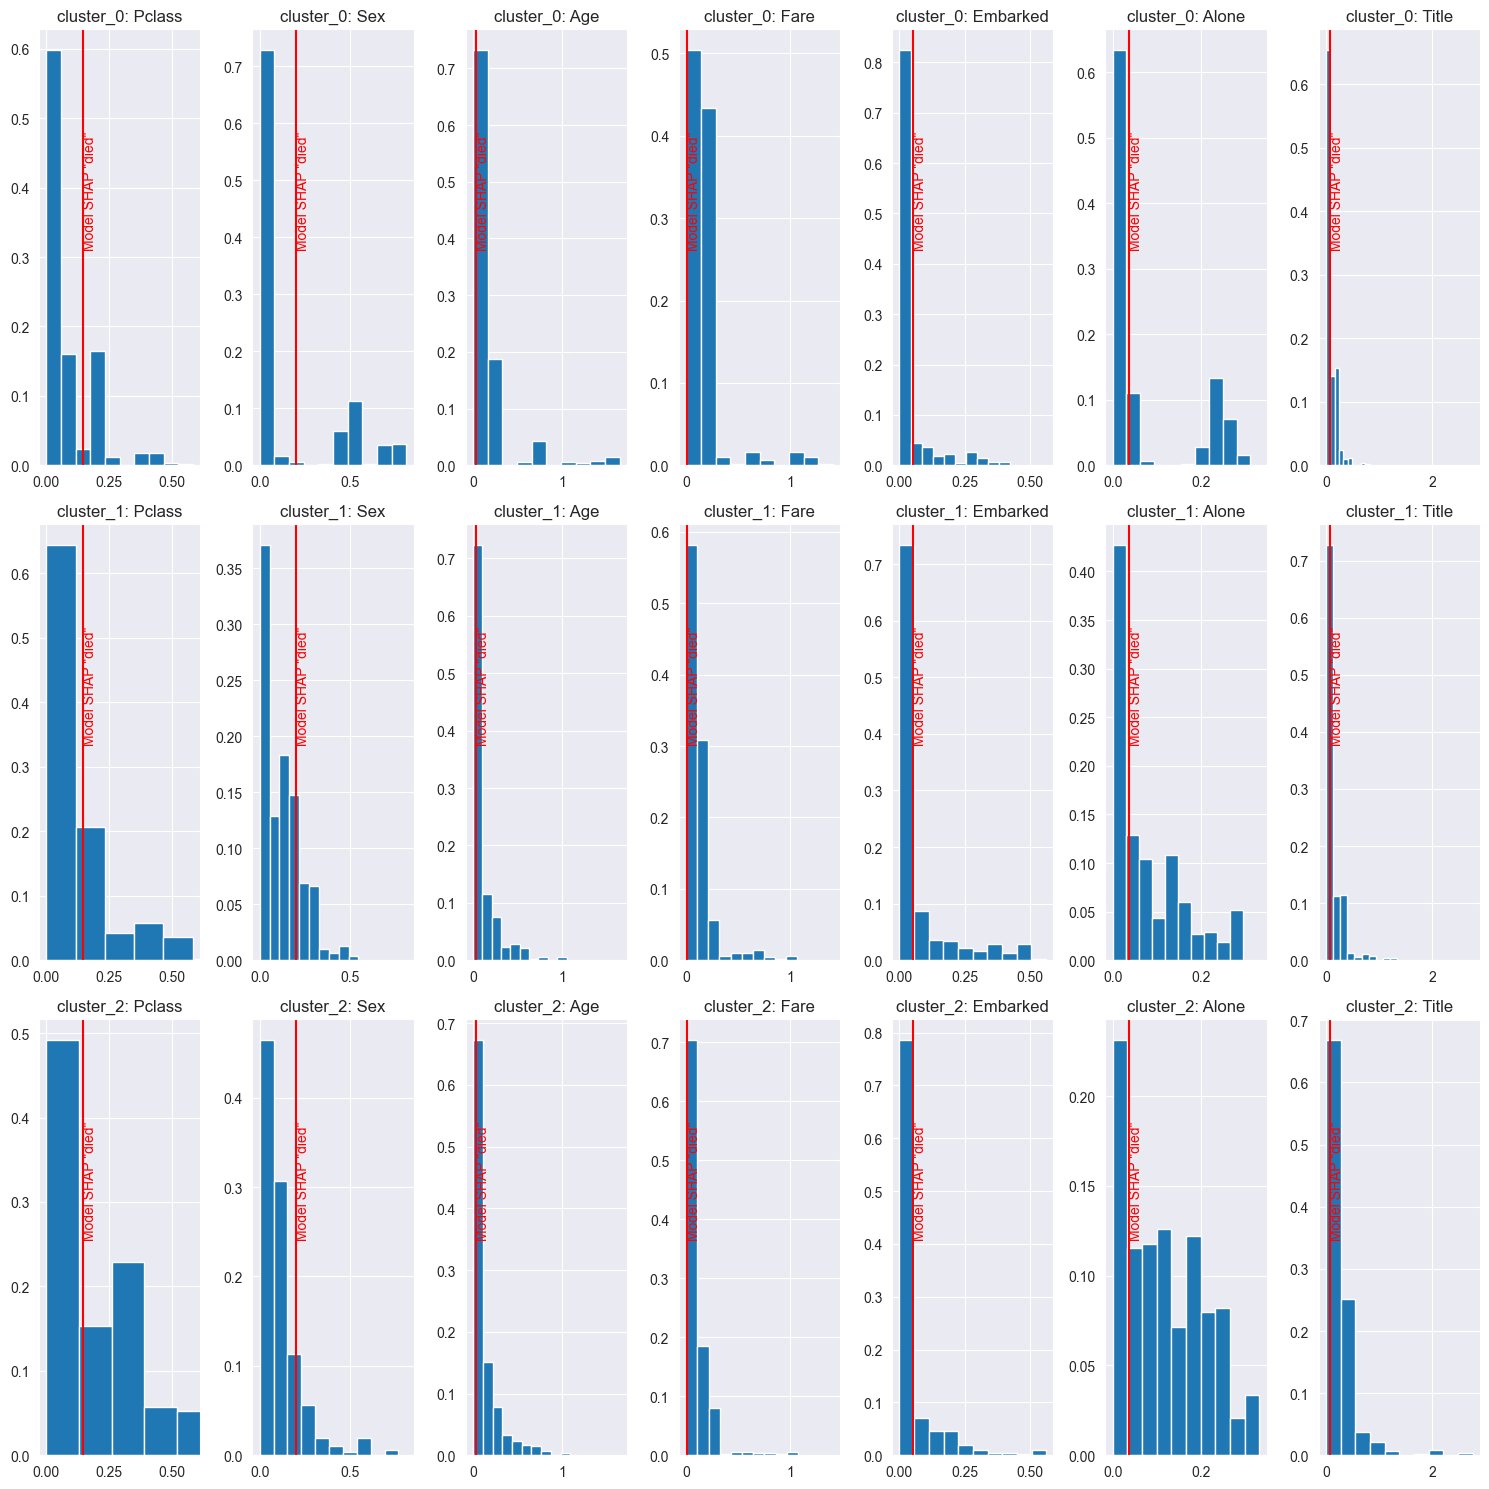

In [115]:
n = len(clusters) * len(X_train.columns)
cols = len(X_train.columns)
fig, axs = plt.subplots(nrows=int(np.ceil(n / cols)),
                        ncols=min(n, cols),
                        figsize=(15, 5 * int(np.ceil(n / cols))))
num = 0
x_lims = []
normalize_x_axis = True
for cluster, feature_svs in shap_values_per_cluster.items():
    for feature, sv in feature_svs.items():
        ax = axs[num // cols, num % cols]
        data = np.abs(sv)
        ax.hist(np.abs(sv),
                weights=np.zeros_like(data) + 1. / data.size)  # add histogram to the current axis, make absolute
        model_shap_died = died_mean_shap_vals[feature]
        model_shap_survived = survived_mean_shap_vals[feature]
        ylim = ax.get_ylim()  # Get the y-axis limits
        ypos = (ylim[1] - ylim[0]) / 2 + ylim[0]
        ax.axvline(model_shap_died, color='red')
        ax.text(model_shap_died, ypos, 'Model SHAP "died"', rotation=90, color='red')
        # ax.axvline(model_shap_survived, color='green')
        # ax.text(model_shap_survived, ypos, 'Model SHAP "survived"', rotation=90, color='green')
        ax.set_title(f'{cluster}: {feature}')  # add title to the axis

        # Add the x limits of the current axis to the list of x limits for the current column
        if num % cols == 0:
            x_lims.append(ax.get_xlim())
        else:
            if num % cols < len(x_lims):
                x_lims[num % cols] = ax.get_xlim() if ax.get_xlim()[0] < x_lims[num % cols][0] else x_lims[num % cols]
            else:
                x_lims.append(ax.get_xlim())

        num += 1

if normalize_x_axis:
    # Set the same x limits for all the axes in each column
    for i in range(cols):
        for j in range(int(np.ceil(n / cols))):
            axs[j, i].set_xlim(x_lims[i])

# adjust layout and show plot
fig.tight_layout()
plt.show()
